In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [3]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [4]:
W = 10
H = 5
d = H
V_eq = doulbe_well_width_height(xref, W, H, xavg, d)
F_eq = force_doulbe_well_width_height(xref, W, H, xavg)
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq

## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [5]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [6]:
# Read simulated trajectory from jld file
f_in = "../trajectory/doublewell_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
W = load(f_in, "W")
H = load(f_in, "H")
D = load(f_in, "D");

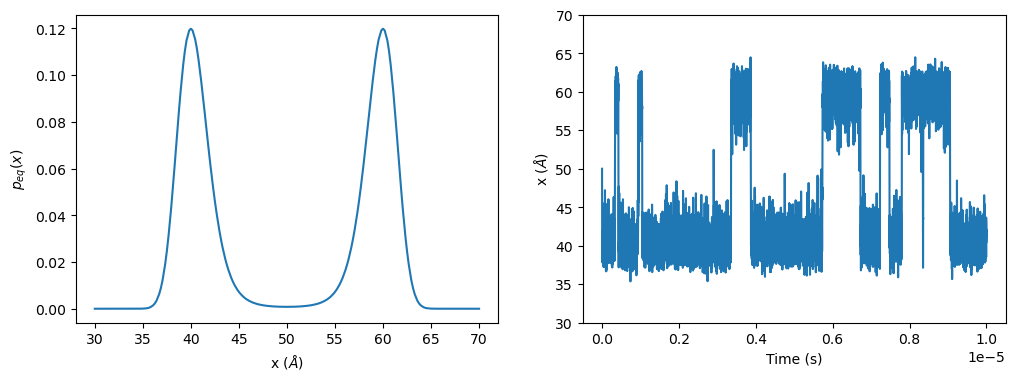

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Complete EM

In [9]:
# Set Parameters
Nv = 72
max_n_iteration = 100

f_out_pcontain = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_kde_pref_doublewell_xavg_%d.jld"  xavg
f_out_d_record = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_kde_pref_doublewell_xavg_%d_D.jld"  xavg
f_out_l_record = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_kde_pref_doublewell_xavg_%d_loglikelihood.jld"  xavg

"/home/yizaochen/codes/julia/EM_data/p0_kde_pref_doublewell_xavg_50_loglikelihood.jld"

In [10]:
p_container, D_records, log_likelihood_records = complete_em_v0(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record);

Iteration-ID: 1
Iteration-ID: 2


LoadError: SingularException(0)

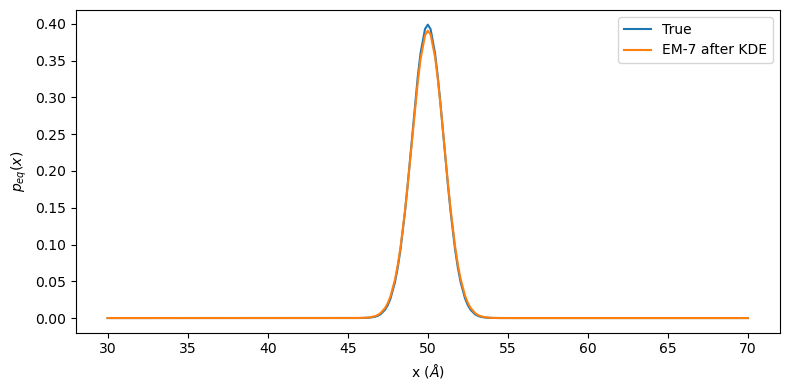

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_container[7,:], label="EM-7 after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()

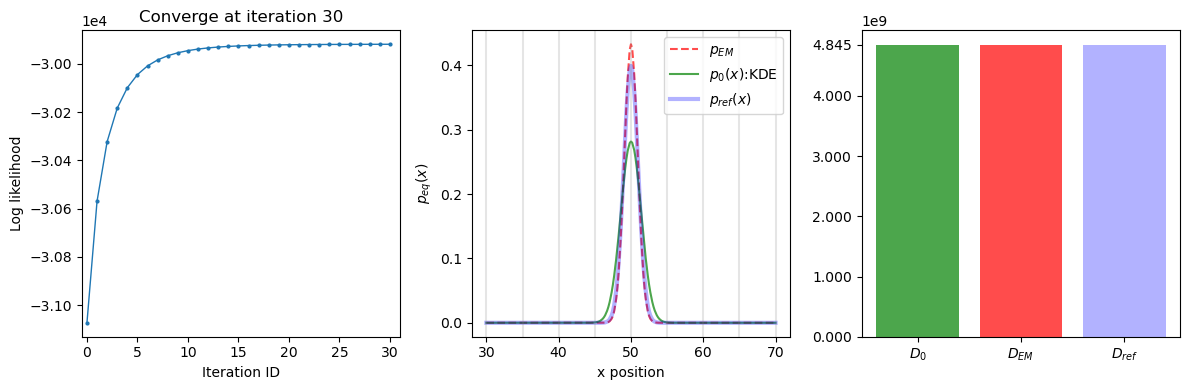

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

lastem_id = 30

ax = axes[1]
xarray = 0:lastem_id
ax.plot(xarray, log_likelihood_records[1:lastem_id+1], "-o", linewidth=1, markersize=2)
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, lastem_id+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
title = @sprintf "Converge at iteration %d" lastem_id
ax.set_title(title)

ax = axes[2]
ax.plot(xref, p_container[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{EM}\$")
ax.plot(xref, p_container[1,:], label="\$ p_0(x) \$:KDE", alpha=0.7, color="green")
ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
for xline in 30:5:70
    ax.axvline(xline, color="grey", alpha=0.2)
end
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[3]
xarray = [1, 2, 3]
label1 = @sprintf "%.3E" D_records[1]
label2 = @sprintf "%.3E" D_records[lastem_id+1]
label3 = @sprintf "%.3E" D
ax.bar(1, D_records[1], color="green", alpha=0.7, label=label1)
ax.bar(2, D_records[lastem_id+1], color="red", alpha=0.7, label=label2)
ax.bar(3, D, color="blue", alpha=0.3, label=label3)
ax.set_xticks(xarray)
ax.set_xticklabels(["\$D_0\$", "\$D_{EM}\$", "\$D_{ref}\$"])
ax.set_yticks([0e9,1e9,2e9,3e9,4e9,D_records[1]])

plt.tight_layout()
#svgfile = @sprintf "./em_p0_kde_pref_xavg_%d.svg" xavg
#plt.savefig(svgfile)
plt.show()